# Making a Pull Plot

Let's use a background-only workspace that we've bundled with the tutorial. It's a little bit more complicated than the simple workspace we've seen in the past, but it will be a bit easier to demonstrate the efficacy of pulls this way.

## Loading the workspace

In [1]:
import pyhf
import json
import numpy as np

with open("data/bkg_only.json") as serialized:
  spec = json.load(serialized)

workspace = pyhf.Workspace(spec)

### Model and Data

In [2]:
model = workspace.model(
    modifier_settings={
        "normsys": {"interpcode": "code4"},
        "histosys": {"interpcode": "code4p"},
    },
    poi_name=None # background-only!
)
data = workspace.data(model)

## Making a Pull Plot

We need to use minuit in order to perform the fits. So first we'll set our backends to use numpy and minuit. Then we'll do a bunch of setup to make it easier to compute the pulls. Work is on-going in `pyhf` to streamline this a bit more and put it into `pyhf.contrib`.

Unlike the `scipy` optimizer, `minuit` provides the uncertainties on the parameters which we need for the pulls.

In [3]:
pyhf.set_backend('numpy', 'minuit')

### Performing the Fit

In the past, we've done a hypothesis test which does multiple fits, both constrained and unconstrained fits. Instead, we will need to perform an unconstrained fit on the background in order to determine the fluctuation of all the parameters and the corresponding pulls.

In [4]:
result = pyhf.infer.mle.fit(
    data,
    model,
    return_uncertainties=True
)

With `return_uncertainties=True`, we return, instead of just a 1-dimensional vector of the fitted parameter values, a 2-dimensional vector including the fitted parameter uncertainties as well.

In [5]:
result[:5]

array([[-0.20539975,  0.98833827],
       [-0.16386659,  0.97922859],
       [-0.02117485,  0.9927666 ],
       [-0.0386397 ,  1.0883845 ],
       [ 0.        ,  0.99334679]])

So let's split this up to handle.

In [6]:
bestfit, errors = result.T

### Normalize to natural width

Now we need to compute the pulls. In order to do so, we need to determine the constrained parameters of the model. We can do this by looping over the ordered parameters of the model. `pyhf` maintains a particular order of the parameters as we load them up into a large tensor in a specific order. So we can access this same order of the fitted parameters to the parameter names using `pyhf.Model.config.par_order`:

In [7]:
model.config.par_order

['EG_Eff',
 'EG_Iso',
 'EG_Reco',
 'EG_RESOLUTION_ALL',
 'EG_SCALE_AF2',
 'EG_SCALE_ALL',
 'JER_DataVsMC',
 'JER_EffectiveNP_1',
 'JER_EffectiveNP_10',
 'JER_EffectiveNP_11',
 'JER_EffectiveNP_12restTerm',
 'JER_EffectiveNP_2',
 'JER_EffectiveNP_3',
 'JER_EffectiveNP_4',
 'JER_EffectiveNP_5',
 'JER_EffectiveNP_6',
 'JER_EffectiveNP_7',
 'JER_EffectiveNP_8',
 'JER_EffectiveNP_9']

So first, we'll compute the pulls. This is done by calculating the difference between the fitted parameter value, the initial value, and divide by the width of that constrained parameter

$$
\text{pull} = \frac{\hat{\chi} - \chi}{\sigma}
$$

In [8]:
pulls = pyhf.tensorlib.concatenate(
    [
        (bestfit[model.config.par_slice(k)] - model.config.param_set(k).suggested_init)
        / model.config.param_set(k).width()
        for k in model.config.par_order
        if model.config.param_set(k).constrained
    ]
)

We can also do this similarly for the error on the parameter as well:

In [9]:
pullerr = pyhf.tensorlib.concatenate(
    [
        errors[model.config.par_slice(k)] / model.config.param_set(k).width()
        for k in model.config.par_order
        if model.config.param_set(k).constrained
    ]
)

Finally, we just need to create a set of labels for the parameters that were constrained that we are showing pulls for.

In [10]:
labels = np.asarray(
    [
        "{}[{}]".format(k, i) if model.config.param_set(k).n_parameters > 1 else k
        for k in model.config.par_order
        if model.config.param_set(k).constrained
        for i in range(model.config.param_set(k).n_parameters)
    ]
)

### Order Results

Now we need to sort the labels in alphabetical order to make things easier for the user to read. We'll figure out the sort order we need using `np.argsort` and apply that ordering to everything we've created.

In [11]:
_order = np.argsort(labels)
bestfit = bestfit[_order]
errors = errors[_order]
labels = labels[_order]
pulls = pulls[_order]
pullerr = pullerr[_order]

### Plotting Results

Now we can finally make a plot to appease our supervisor!

/home/feickert/.venvs/louie-test/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


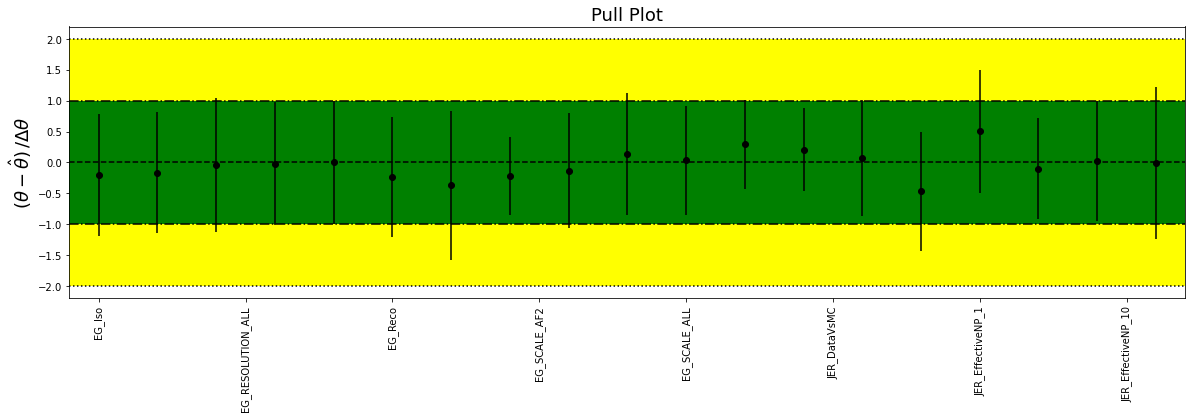

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(20, 5)

# set up axes labeling, ranges, etc...
ax.set_xticklabels(labels, rotation=90)
ax.set_xlim(-0.5, len(pulls) - 0.5)
ax.set_title("Pull Plot", fontsize=18)
ax.set_ylabel(r"$(\theta - \hat{\theta})\,/ \Delta \theta$", fontsize=18)

# let's make the +/- 2.0 horizontal lines
ax.hlines([-2, 2], -0.5, len(pulls) - 0.5, colors="k", linestyles="dotted")
# let's make the +/- 1.0 horizontal lines
ax.hlines([-1, 1], -0.5, len(pulls) - 0.5, colors="k", linestyles="dashdot")
# let's make the +/- 2.0 sigma band
ax.fill_between([-0.5, len(pulls) - 0.5], [-2, -2], [2, 2], facecolor="yellow")
# let's make the +/- 1.0 sigma band
ax.fill_between([-0.5, len(pulls) - 0.5], [-1, -1], [1, 1], facecolor="green")
# let's draw a horizontal line at pull=0.0
ax.hlines([0], -0.5, len(pulls) - 0.5, colors="k", linestyles="dashed")
# finally draw the pulls
ax.scatter(range(len(pulls)), pulls, c="k")
# and their errors
ax.errorbar(
    range(len(pulls)), pulls, c="k", xerr=0, yerr=pullerr, marker=".", fmt="none"
);